In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

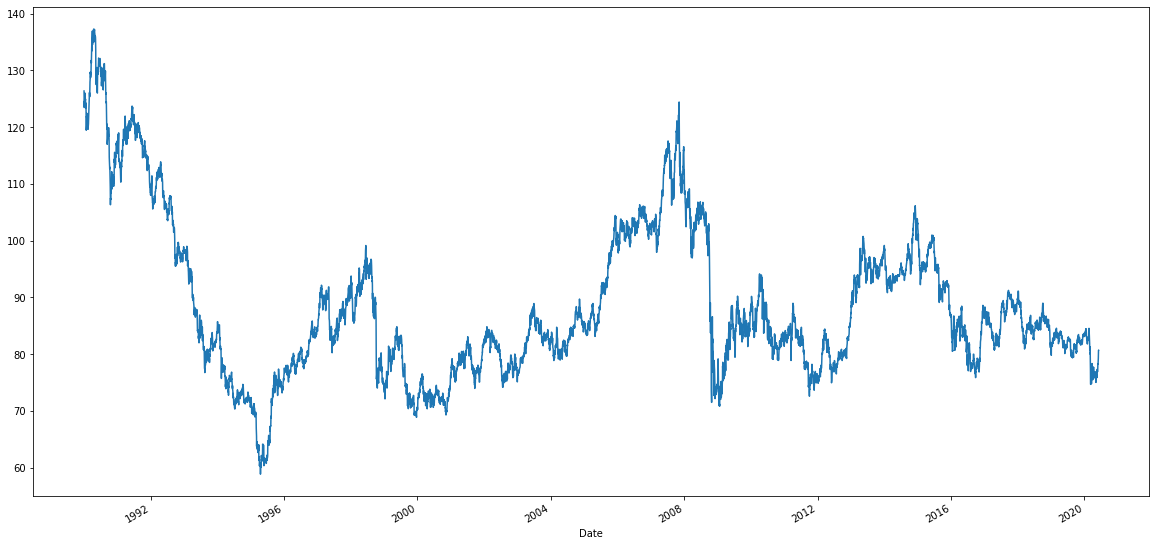

In [4]:
# Plot just the "Price" column from the dataframe:
# YOUR CODE HERE!
cad_jpy_df.Price.plot(figsize=(20,10))

**Question:** Do you see any patterns, long-term and/or short? 

Due to Volatility patterns seem to bee short term


# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [5]:
# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
# YOUR CODE HERE!
import statsmodels.api as sm

noise, trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])

In [6]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!
ns = pd.DataFrame(noise)
ns = ns.rename(columns={
    "Price_cycle": "noise"
})

#ns.head()
trn = pd.DataFrame(trend)
trn = trn.rename(columns={
    "Price_trend": "trend"
})

exchn_df =  pd.DataFrame(cad_jpy_df["Price"])
exchn_df.head()

club_data = pd.concat([exchn_df,ns, trn], axis = "columns", join = "inner")
club_data


,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037
...,...,...,...
2020-05-29,78.29,-0.503961,78.793961
2020-06-01,79.27,0.218939,79.051061
2020-06-02,80.40,1.088117,79.311883


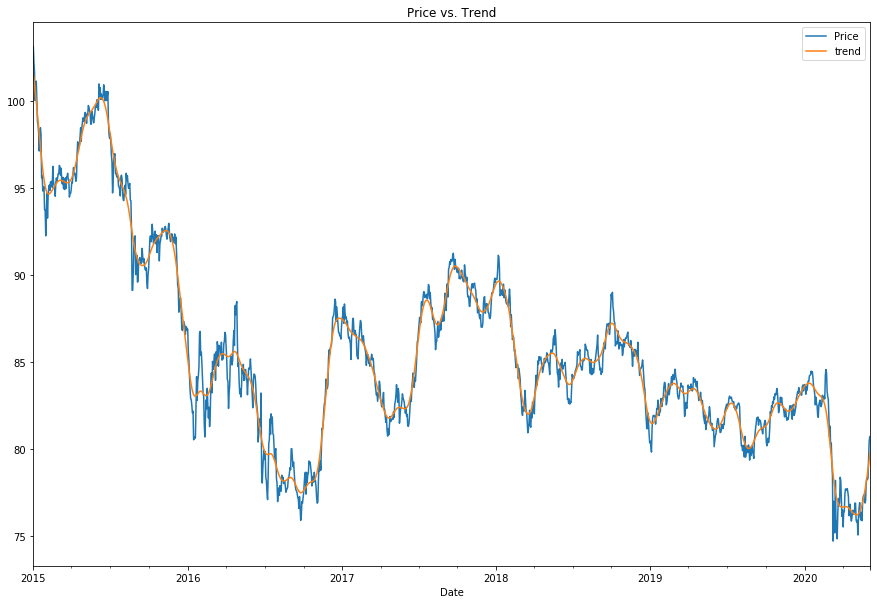

In [11]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
# YOUR CODE HERE!
newdata = club_data.loc["2015-01-01" :, :]
                       
newdata = newdata.drop(columns=["noise"])
newdata.plot(figsize=(15,10),title='Price vs. Trend')
#newdata.plot(y = ["Price", "trend"],title='Price vs. Trend')

**Question:** Do you see any patterns, long-term and/or short?

Despite the noises throughout the 5 year period the patterns depict short term fluctuations

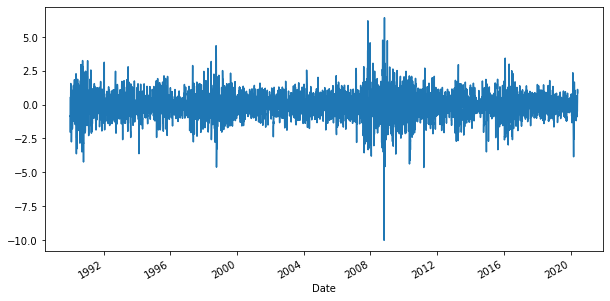

In [7]:
# Plot the Settle Noise
# YOUR CODE HERE!
noise.plot(figsize=(10,5))

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [8]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [9]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!
model = ARMA(returns.values, order =(2,1))
# Fit the model and assign it to a variable called results
# YOUR CODE HERE!
results = model.fit()

In [10]:
# Output model summary results:
# YOUR CODE HERE!
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Fri, 27 Nov 2020   AIC                          19513.955
Time:                        03:59:44   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1703           +0.0000j           42.1703            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

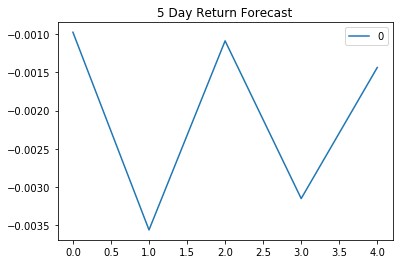

In [17]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!
pd.DataFrame(results.forecast(steps = 5)[0]).plot(title = "5 Day Return Forecast")

**Question:** Based on the p-value, is the model a good fit?

based on the calculation ARMA model is not a good fit as P in this model is not less than 0.05

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [11]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!
model1 = ARIMA(cad_jpy_df["Price"], order = (5,1,1))
# Fit the model
# YOUR CODE HERE!
results1 = model1.fit()

C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [12]:
# Output model summary results:
# YOUR CODE HERE!
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Fri, 27 Nov 2020   AIC                          17507.244
Time:                        03:59:51   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.856      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1892           +0.0000j            2.1892            0.0000
-----------------------------------------------------------------------------
"""

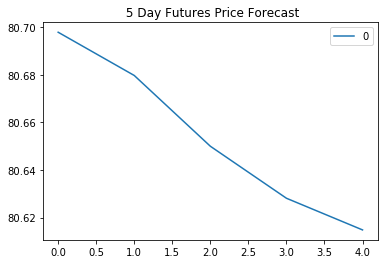

In [13]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!
pd.DataFrame(results1.forecast(steps = 5)[0]).plot(title = " 5 Day Futures Price Forecast")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

As per the graph model depicts the strenghtening of yen in the upcoming days

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [18]:
import arch as arch

In [19]:
# Estimate a GARCH model:
# YOUR CODE HERE!
#model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)
model = arch.arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)
# Fit the model
# YOUR CODE HERE!
res= model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8943.240855480453
Iteration:      2,   Func. Count:     17,   Neg. LLF: 8937.945261935267
Iteration:      3,   Func. Count:     24,   Neg. LLF: 8932.682518473754
Iteration:      4,   Func. Count:     30,   Neg. LLF: 8928.838567263532
Iteration:      5,   Func. Count:     37,   Neg. LLF: 8922.47303011658
Iteration:      6,   Func. Count:     46,   Neg. LLF: 8914.626136681025
Iteration:      7,   Func. Count:     53,   Neg. LLF: 8913.390285115445
Iteration:      8,   Func. Count:     59,   Neg. LLF: 8911.11188643532
Iteration:      9,   Func. Count:     65,   Neg. LLF: 8911.027367056668
Iteration:     10,   Func. Count:     71,   Neg. LLF: 8911.022006069103
Iteration:     11,   Func. Count:     77,   Neg. LLF: 8911.02100232603
Iteration:     12,   Func. Count:     83,   Neg. LLF: 8911.020890110218
Iteration:     13,   Func. Count:     89,   Neg. LLF: 8911.020841303722
Optimization terminated successfully.    (Exit mode 0)
            

In [20]:
# Summarize the model results
# YOUR CODE HERE!
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Fri, Nov 27 2020   Df Residuals:                     7924
Time:                        04:02:27   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]   2.7064e-07  2.010e-02  1.346e-05      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [22]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [39]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
#forecasts = results.forecast(start = last_day, horizon = forecast_horizon)
forecasts = res.forecast(start=last_day, horizon=forecast_horizon)
#forecasts = results.forecast(start=last_day, horizon=forecast_horizon)
#forecasts = res.forecast(start='2009-12-31', horizon=forecast_horizon)

In [40]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566012,12.573698,12.58128,12.588757,12.596131


In [42]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566012
h.2,12.573698
h.3,12.581280
h.4,12.588757
h.5,12.596131


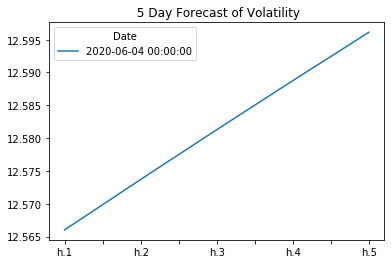

In [43]:
# Plot the final forecast
# YOUR CODE HERE!
final.plot(title = ' 5 Day Forecast of Volatility')

**Question:** What does the model forecast will happen to volatility in the near term?

it shows om the coming 5 days volatility is increasing.

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * As is depends on the Risk appetite of the investor, and in my opinion and considering the volatility and strengthening of Yen I would restrain from buying Yen at present.

2. Is the risk of the yen expected to increase or decrease?
    *    Considering the pas trend and GARCH model it shows the increase in volatality therefore risk is increasing

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * based on my calculation and working i will definately rely on the trading models
    